<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# OpenEO Platform - UC 3+6
Spatial & temporal analysis of different land cover types

In [141]:
import openeo
from eo_utils import *
from openeo.processes import ProcessBuilder, array_modify, normalized_difference, drop_dimension
from matplotlib import pyplot as plt
from shapely.geometry import box
from openeo.rest.conversions import timeseries_json_to_pandas
import pandas as pd

In this notebook we will do some data exploration for different types of crops, both spatially and temporally. In the first use case, we will calculate a vegetation index and compare the greenness of several plots selected by you on a map. In the second use case we will do some spatial plotting in which we will look at a.o. the length of the growing season of different pixels within the polygon you have selected.

Step 1: Select a polygon on the map below. For the sake of the analysis below, make sure your polygon covers just one land use type (for example, a forest, a field or a small group of fields).

In [144]:
center = [50.8, 4.75]
zoom = 13

eoMap = openeoMap(center,zoom)
addS2Tiles(eoMap)
eoMap.map

Map(center=[50.8, 4.75], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

In [165]:
bbox = eoMap.getBbox()

Fill in the land cover type that you think the polygon you selected contains.

In [166]:
lc_polygon = "Potato"

## Load the dataset

Step 2: *Connect* to the vito backend and load bands 4 (RED), 8 (NIR) and the scene classification layer (SCL). This last layer will be used for cloud masking. The calculations will be done for the polygon you selected in the previous step, and it will take all images from 2018.
After that, use the scene classification band to perform *cloud masking* and we drop the SCL layer as we will not need it anymore.

In [167]:
connection = openeo.connect("https://openeo-dev.vito.be").authenticate_oidc(provider_id="egi")
s2 = connection.load_collection("SENTINEL2_L2A_SENTINELHUB", 
                                spatial_extent={'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}, 
                                temporal_extent=["2018-01-01", "2019-01-01"], 
                                bands=["B04","B08","SCL"])
s2_masked = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCENECLASSIFICATION_20M").filter_bands(["B04","B08"])

Authenticated using refresh token.


Step 3: The next step is to create 10-day periods by reducing the timeseries using the median, and interpolate linearly the 10-day composites for which no data was available.

In [187]:
composite = s2_masked.aggregate_temporal_period(period="dekad", reducer="median")
interpolated = composite.apply_dimension(dimension="t", process="array_interpolate_linear")

## Use case 1: timeseries analysis of vegetation greenness

In this use case we want to have a look at vegetation greenness over time. Different land cover types can be identified by their seasonal greenup / greendown patterns. For example, coniferous forests are green all year round and have little variation in  greenness over time, while crops like sugar beet and maize are characterized by strong seasonal fluctuations. An overview of several crops types is displayed below.

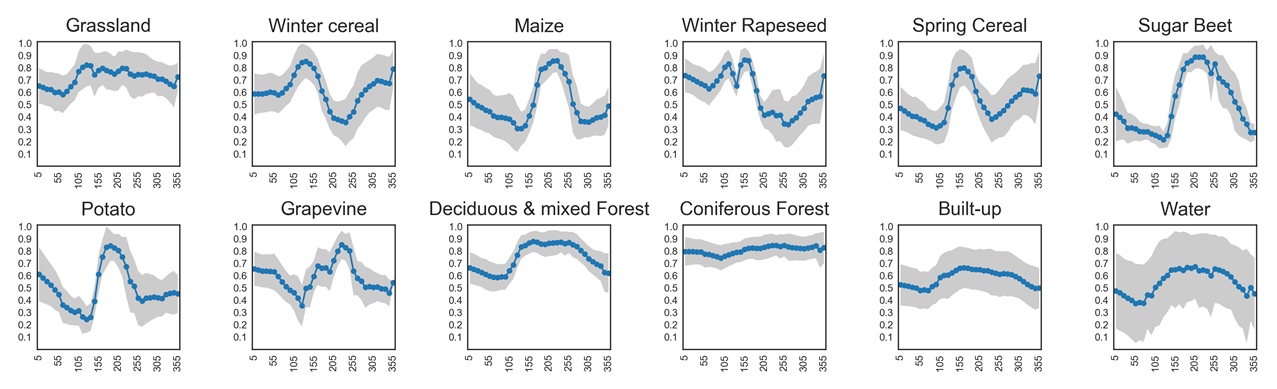

Step 4: To make a similar seasonal plot for the area you selected in the map above, we want to first calculate a vegetation index such as the NDVI or the EVI. To do so, we need to define a callback function that can be passed to the process parameter of apply_dimension.

In [188]:
def ndvi_callback(x:ProcessBuilder):
    """The normalized_difference function calculates (band1 - band2) / (band1 + band2)
    the formula for NDVI is (NIR - red) / (NIR + red)
    so first we need to pass NIR, then red"""
    red = x.array_element(0) ### Band "B04"
    nir = x.array_element(1) ### Band "B08"

    return array_modify(data=x,values=normalized_difference(nir, red),index=0)

extended_ndvi = interpolated.apply_dimension(dimension="bands",process=ndvi_callback)

In [191]:
# TODO: Gooi hier een smoothing overheen en dan misschien kleinere tijdsinterval dan dekad (week?)

Step 5: This NDVI is calculated for every pixel in every time step t in the masked NIR/red image that we extracted from SentinelHub. Now we want to aggregate the polygon you selected spatially to end up with a timeseries by calculating the mean over all the pixels as well as the standard deviation, to have an indication of the error. The more homogeneous the area you selected is, the smaller your error will be.

In [189]:
timeseries = extended_ndvi.band(0).aggregate_spatial(reducer="median", geometries=box(*bbox)).execute()
timeseries_sd = extended_ndvi.band(0).aggregate_spatial(reducer="sd", geometries=box(*bbox)).execute()

Finally, we can plot the mean and standard deviation for the plot you selected. Compare your results with the image above. Are your results as expected? Feel free to select a polygon on the map and run the code once more to compare your results.

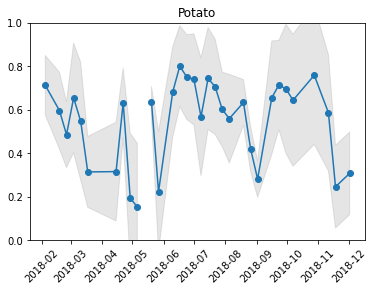

In [190]:
timeser = pd.concat([timeseries_json_to_pandas(timeseries),timeseries_json_to_pandas(timeseries_sd)], axis=1)
timeser.columns = ["Median NDVI", "SD"]
timeser.index = pd.to_datetime(timeser.index)
timeser = timeser.sort_index()

plt.plot(timeser["Median NDVI"],"o-")
plt.fill_between(timeser.index,
                 timeser["Median NDVI"] - timeser["SD"], 
                 timeser["Median NDVI"] + timeser["SD"],
                 color='gray', alpha=0.2)
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.title(lc_polygon)
plt.show()

## Use case 2: spatial analysis of EVI and growing season

For this use case, we want to have a look at the EVI index and other parameters that we can derive from the EVI. First, we will calculate the EVI and its amplitude, which tells us something about the fluctuation of greenness over the growing season, and then we will use that amplitude to calculate the start and end of the growing season. The image below shows a visual representation of this amplitude and the overall variation of the EVI of a summer annual in the northern hemisphere.

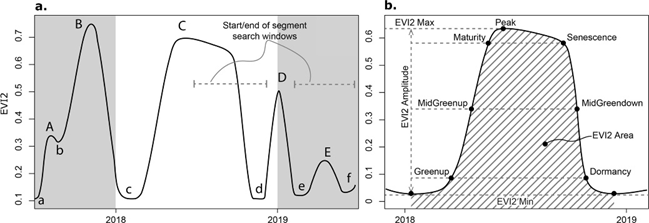

In [43]:
def evi2_callback(x:ProcessBuilder):
    red = x.array_element(0) ### Band "B04"
    nir = x.array_element(1) ### Band "B08"
    evi2 = lambda red,nir: 2.5 * (nir - red) / (nir + 2.4 * red + 1.0)

    return array_modify(data=x,values=evi2(red, nir),index=0)

#compute temporal features # stond reducer ipv process
# extended_evi2 = extended_ndvi.apply_dimension(dimension="t",target_dimension="bands",process=evi2_callback)#"lambda timeseries:array_modify([],quantiles(timeseries,q=[0.9,0.5,0.1]),0)")#,sd(timeseries)
extended_evi2 = extended_ndvi.apply_dimension(dimension="bands",process=evi2_callback)

One of the things we can do is to calculate some parameters from this EVI2 timeseries over 2018. For example, we can calculate the amplitude of the EVI2, which equates to the absolute difference between the highest and the lowest EVI value of that particular pixel. This tells us something about the difference in greenness of that pixel. We can expect this amplitude to be high in for example deciduous forests, particularly in latitudes that exhibit strong seasonality yet are warm enough to have greenup in summer.

In [8]:
evi2_min = extended_evi2.band(0).min_time()
evi2_max = extended_evi2.band(0).max_time()
evi2_amplitude = evi2_max - evi2_min

A pretty estimate of the start and end of the growing season can be calculated by setting a threshold on the ratio of amplitude to minimum of the season. In a study by Suepa et al. (2016) (https://www.sciencedirect.com/science/article/pii/S0013935116300482) this threshold was set to 20%. 

In [ ]:
## smooth de timeseries

In [9]:
x = np.array([0., 0., .1, .1, .2, .4, .4, .8, .8, .9, .5, .4, .3, 0., 0.,])
cutoff = .15
start_grow_season = np.where(x > cutoff)[0][0]
end_grow_season = np.where(x > cutoff)[0][-1]
print(start_grow_season, end_grow_season)

4 12


In [23]:
def evi2_growingseason_callback(x:ProcessBuilder):
#     cutoff = 0.2
#     for count, raster_t in enumerate(x):
        ## met die i in de for loop hoop ik een heel raster te krijgen per tijdsunit t
        ## cutoff formule (i - evi2_min) / evi2_amplitude > 0.2
    cutoff_cube = ((x - ProcessBuilder(evi2_min._pg)) / ProcessBuilder(evi2_amplitude._pg)).gt(0.2)
    start_grow_season = cutoff_cube.array_find(True)
#     end_grow_season = cutoff_cube.array_find(True) ## cutoff_cube[:, ::-1] np.fliplr(cutoff_cube) of np.flip(cutoff_cube,axis=1)
    return start_grow_season #end_grow_season - start_grow_season

## of mss een apply dimension met dan 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 voor begin growing season dan 1
# start_grow = extended_evi2.band(0).reduce_dimension("t", reducer=evi2_growingseason_callback)
start_grow = extended_evi2.band(0).apply_dimension(dimension="t", process=evi2_growingseason_callback)

In [24]:
def evi2_amplitude_callback(x:ProcessBuilder):
    maxevi = x.max()
    minevi = x.min()
    return maxevi - minevi
    
evi2_amplitude = extended_evi2.band(0).apply_dimension(dimension="t",process=evi2_amplitude_callback)    
# extended_evi2 = extended_ndvi.apply_dimension(dimension="t",target_dimension="bands",process=evi2_callback)#"lambda timeseries:array_modify([],quantiles(timeseries,q=[0.9,0.5,0.1]),0)")#,sd(timeseries)

In [44]:




%time start_grow.download("./data/start_grow.tif", format="GTiff")
## handig
# connection.list_processes()

# %time features.download("./data/features.tif", format="GTiff")
# s2_comp = xr.open_rasterio("./data/extended_evi2.tif")
# print('INTERPOLATED OUTPUT:')
# print(s2_comp)

# # brg_icor = tone_mapping(s2_comp[2],s2_comp[1],s2_comp[0])
# # plt.imshow(brg_icor,cmap='brg')

Wall time: 54.2 s


In [230]:
np.round([bbox[0],bbox[2],bbox[1],bbox[3]],3)

array([ 4.739,  4.743, 50.798, 50.801])

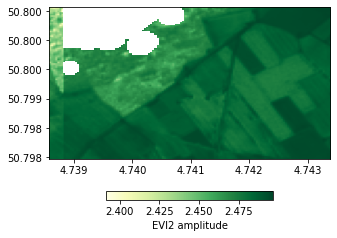

In [276]:
from matplotlib.ticker import FormatStrFormatter


with rasterio.open('./data/extended_evi2.tif',mode="r+",crs=rasterio.crs.CRS({"init": "epsg:4326"})) as dataset:
#     dataset.coords = bbox
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f')); ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    plt.imshow(dataset.read(1), cmap='YlGn',extent=[bbox[0],bbox[2],bbox[1],bbox[3]]) ## read(1) is band0, read(2) band1, etc.
    plt.colorbar(orientation="horizontal",shrink=.5).set_label("EVI2 amplitude",loc="center")
    plt.show()


In [139]:
# timeseries = timeseries.merge_cubes(timeseries_sd) ## maar dit werkt dan weer niet. is wel nog cube maar wordt geconvert naar AggregatePolygonResult ???
# %time timeseries.save_result("CSV","./data/timeser.csv") ### dit werkte dan uiteindelijk.
# %time timeseries_sd.download(outputfile="./data/timeser_sd.csv", format="CSV")